# Preparations

In [13]:
import sys
import math
import numpy as np

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference import settings

In [14]:
colors = ['C0', 'C2', 'C3', 'C4', 'C5', 'C6']

def lighter_color(color, fraction_white=0.7):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

# Data for baseline

In [38]:
metrics_filenames = [#'loss',
                     'mse_logr',
                     'ce',
                     'mse_scores']
metrics_labels = [#'Loss',
                  r'MSE $\log \ r$',
                  'Cross entropy',
                  'MSE scores']
n_metrics = len(metrics_filenames)
metrics_log = [#True,
               False,
               False,
               False]
metrics_min = [#None,
               -0.005,
               0.6565,
               -0.1]
metrics_max = [#None,
               0.14,
               0.668,
               3.]
metrics_optimal = [#0.,
                   0.,
                   0.657932534292,
                   0.]

strategies_filenames = ['carl_random_shallow',
                        'combined_random',
                        'regression_random',
                        'combinedregression_random',
                        'carl_smeared',
                        'combined_smeared',
                        'regression_smeared',
                        'combinedregression_smeared']
strategies_folders = ['parameterized'] * len(strategies_filenames)
strategies_labels = ['carl',
                     'carl + score regr.',
                     'ratio regression',
                     'ratio + score regr.',
                     'carl',
                     'carl + score regr.',
                     'ratio regression',
                     'ratio + score regr.']
strategies_panel = [0, 0, 0, 0,
                   1, 1, 1, 1]
n_panels = max(strategies_panel) + 1


In [39]:
metrics = []  # Indexed by [strategy][metric][train/validation][epoch]
detailed_metrics = []  # Indexed by [strategy][metric][batch] (only available on train)
result_dir = '../results'

for sfile, sfolder in zip(strategies_filenames, strategies_folders):
    line1 = []
    line2 = []
    for met in metrics_filenames:
        line1.append(np.load(result_dir + '/' + sfolder + '/traininghistory_' + met + '_' + sfile + '.npy') )
        line2.append(np.load(result_dir + '/' + sfolder + '/traininghistory_100batches_' + met + '_' + sfile + '.npy') )
    metrics.append(line1)
    detailed_metrics.append(line2)
    

In [40]:
n_reduce = 30
coarsegrained_detailed_metrics = []

for strategy_results in detailed_metrics:
    
    coarsegrained_strategy_results = []
    
    for metric_results in strategy_results:
        
        coarsegrained_metric_results = []
        
        n_batches = len(metric_results)

        lower = - n_reduce
        upper = 0

        while upper < n_batches:
            lower += n_reduce
            upper += n_reduce
            coarsegrained_metric_results.append(np.mean(metric_results[lower:upper]))
            
        coarsegrained_metric_results = np.asarray(coarsegrained_metric_results)
        coarsegrained_strategy_results.append(coarsegrained_metric_results)
        
    coarsegrained_detailed_metrics.append(coarsegrained_strategy_results)
        

# Baseline results

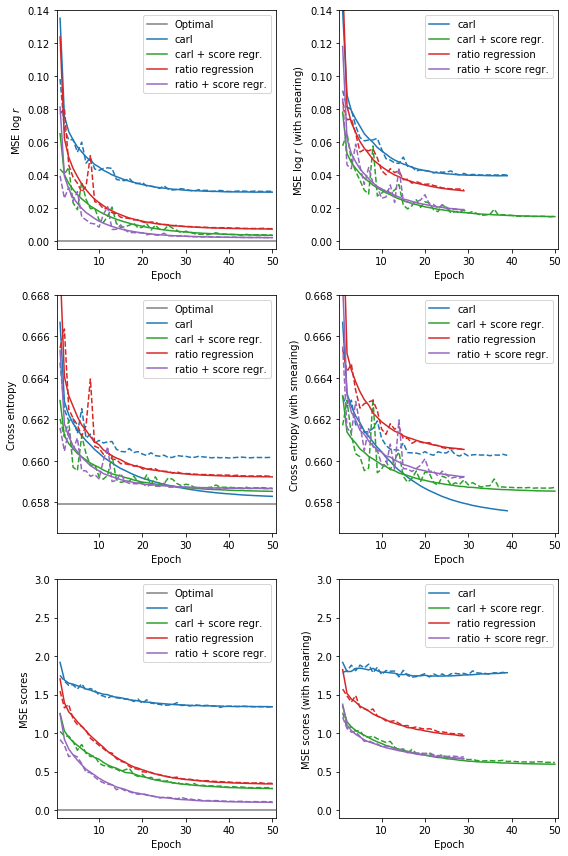

In [41]:
plt.figure(figsize=(n_panels*4., n_metrics*4))

for p in range(n_panels):

    for m, mlabel in enumerate(metrics_labels):
        
        plt.subplot(n_metrics, n_panels, m * n_panels + p + 1)
        
        if False:
            i = 0
            for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
                if spanel != p:
                    continue

                n_epochs = len(metrics[s][m][0])
                n_batches = len(coarsegrained_detailed_metrics[s][m])

                # Per-batch training data
                _y = coarsegrained_detailed_metrics[s][m]
                _x = np.linspace(0.5, n_epochs + 0.5, n_batches)
                plt.plot(_x, _y, c=lighter_color(colors[i]), marker='.', ms=3., ls='', alpha=1.)

                i += 1
                
        if p == 0:
            plt.plot([0.25,50.75], [metrics_optimal[m], metrics_optimal[m]], ls='-', lw=1.5, c='0.5',
                    label='Optimal')
        
        i = 0
        for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
            if spanel != p:
                continue
                
            n_epochs = len(metrics[s][m][0])
            n_batches = len(coarsegrained_detailed_metrics[s][m])

            # Validation set
            _y = metrics[s][m][1]
            _x = np.array(list(range(len(_y)))) + 1
            plt.plot(_x, _y, c=colors[i], lw=1.5, ls='--')
                
            # Training data
            _y = metrics[s][m][0]
            _x = np.linspace(1., n_epochs, n_epochs)
            plt.plot(_x, _y, c=colors[i], lw=1.5, ls='-', label=slabel)
            
            i += 1
        
        plt.legend()
        
        if metrics_log[m]:
            plt.yscale('log')
        plt.ylim(metrics_min[m],metrics_max[m])
        plt.xlim(0.25,50.75)
        
        plt.xlabel('Epoch')
        plt.ylabel(mlabel)
        if p == 1:
            plt.ylabel(mlabel + ' (with smearing)')

plt.tight_layout()
plt.savefig('../figures/learning_curves/learning_curves.pdf')